<a href="https://colab.research.google.com/github/fitzroypet/Detecting-Plant-Disease-using-MobileNet/blob/main/model1_disease_detection_using_mobilenet_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
os.chdir("/content/drive/My Drive/project/")
!ls

 dataset   model.tflite   plantdiseasemobilenet8epoch.h5
 images    Output_bg	 'Tensorflow model'


In [ ]:
root_dir = ('/content/drive/MyDrive/project/dataset/')

In [ ]:
classes = os.listdir(root_dir)
classes

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import splitfolders

In [ ]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/drive/MyDrive/project/dataset/", output="/content/drive/MyDrive/project/Output_bg/",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

Copying files: 18998 files [08:47, 35.98 files/s] 


In [ ]:
# Assign the directories for train, test, and validation dataset

train_dir = '/content/drive/MyDrive/project/Output_bg/train/'
test_dir = '/content/drive/MyDrive/project/Output_bg/test/'
val_dir = '/content/drive/MyDrive/project/Output_bg/val/'

In [ ]:
# Create data generator for training and validation

img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_dir,target_size=(img_width,img_height),batch_size=batch_size,shuffle=True)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(img_width,img_height),batch_size=batch_size)
val_generator = val_datagen.flow_from_directory(val_dir,target_size=(img_width,img_height),batch_size=batch_size)

Found 15195 images belonging to 10 classes.
Found 1906 images belonging to 10 classes.
Found 1897 images belonging to 10 classes.


In [ ]:
# Model architecture, training

from keras.applications.mobilenet import MobileNet
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = Sequential()

model_finetuned.add(MobileNet(weights='imagenet'))
model_finetuned.add(BatchNormalization())
model_finetuned.add(Dense(128, activation="relu"))
model_finetuned.add(Dense(10, activation="softmax"))
for layer in model_finetuned.layers[0].layers:
  if layer.__class__.__name__=="BatchNormalization":
    layer.trainable=True
  else:
    layer.trainable=False
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
model_finetuned.summary()

In [ ]:
# Test if the files are readable

import os
from PIL import Image
folder_path = ('/content/drive/MyDrive/Output/train')
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

In [ ]:
# To test an image 

from pathlib import Path
import PIL
import PIL.Image as PILI
#from PIL import Image

img_path = Path('/content/drive/MyDrive/output/val/Tomato___Bacterial_spot/image (10).png')
img = PILI.open(img_path).convert('RGB')

print(img)

In [ ]:
# Train and fit model

from PIL import Image
from keras.callbacks import ReduceLROnPlateau

#validation_generator = test_datagen.flow_from_directory(
                       #test_dir,
                       #target_size=(img_height, img_width),
                       #batch_size=batch_size)

history_1 = model_finetuned.fit(train_generator,                                    
                                  steps_per_epoch=None, 
                                  epochs=8,validation_data=val_generator,validation_steps=None
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

In [ ]:
from keras.models import load_model
model_finetuned.save('plantdiseasemobilenet8epoch.h5')

In [ ]:
classes=list(train_generator.class_indices.keys())
import numpy as np
import matplotlib.pyplot as plt

# Pre-Processing test data same as train data.
img_width=224
img_height=224
model_finetuned.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#from keras.preprocessing import image
import tensorflow
from keras.preprocessing import image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
 
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)


In [ ]:
import keras.utils as image

In [ ]:
classes = os.listdir('/content/drive/MyDrive/project/Output_bg/train')
classes

In [ ]:
test_img = ('/content/drive/MyDrive/project/Output_bg/test/Tomato___Leaf_Mold/image (163).JPG')
result = model_finetuned.predict([prepare(test_img)])

disease=image.load_img(test_img)
#plt.imshow(test_img)
plt.imshow(disease)
print(result)

In [ ]:
classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

In [ ]:
import tensorflow as tf
keras_model = tf.keras.models.load_model("plantdiseasemobilenet8epoch.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

In [ ]:
model = converter.convert()
file = open('/content/drive/MyDrive/project/Output_bg/outputmobilenetof8epoch.tflite' , 'wb' ) 
file.write(model)

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
model_path=('/content/drive/MyDrive/project/Output_bg/outputmobilenetof8epoch.tflite')
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print("")
print(output_details)

In [ ]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

In [ ]:
input_data = [prepare("/content/drive/MyDrive/project/Output_bg/test/Tomato___Early_blight/image (497).JPG")]

In [ ]:
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_data[0])

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

In [ ]:
classresult=np.argmax(output_data,axis=1)
print(classes[classresult[0]])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


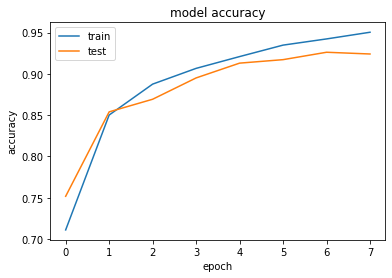

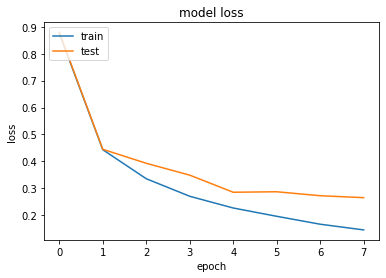

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history_1.history.keys())

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()